In [ ]:
from google.colab import files
uploaded= files.upload()

Saving german.data to german.data


In [ ]:
!pip install shap==0.23.1
#!pip install xgboost==0.72.1

     |████████████████████████████████| 184kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.23.1-cp36-cp36m-linux_x86_64.whl size=230193 sha256=d9a0d2882e373e25349049dbebc3c5b7aa14b603e07e52490849eb78d898ab68
  Stored in directory: /root/.cache/pip/wheels/d6/de/04/90cd2eab45f542feeff51aa672926157db2aa06ff07e879c5e
Successfully built shap


In [ ]:
import pandas as pd
import numpy as np

import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats  import entropy
from scipy.linalg import svd
from sklearn.decomposition import PCA, NMF
import sklearn
import numpy as np
from collections import namedtuple
import pandas as pd
from collections import Counter
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.stats import wasserstein_distance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import shap

#Prepare the dataset

In [ ]:
file_name = "./german.data"

#read file
data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)

data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

# translate from codes to descriptive things
data.replace({"checking_acct": {'A11' : 'lt_0',
 'A12' : '0_to_200',
 'A13' : 'geq_200',
 'A14' : 'no acct'}}, inplace=True)

data.replace({"credit_hist": {'A30' : 'no_cred_all_paid',
 'A31' : 'all_credit_bank_paid',
 'A32' : 'existing_credits_paid',
 'A33' : 'delay_in_past',
 'A34' : 'critical_accts_other_bank_credits'}}, inplace=True)

data.replace({"purpose": {
 'A40' : 'car_new',
 'A41' : 'car_used',
 'A42' : 'furniture_equipment',
 'A43' : 'radio_tv',
 'A44' : 'home_appliances',
 'A45' : 'repairs',
 'A46' : 'education',
 'A47' : 'vacation',
 'A48' : 'retraining',
 'A49' : 'business',
 'A410' : 'other'}}, inplace=True)

data.replace({"savings": {
 'A61' : 'lt_100',
 'A62' : 'lt_500',
 'A63' : '100_to_500',
 'A64' : '500_to_1000',
 'A65' : 'unknown_or_no_account'}}, inplace=True)

data.replace({"employ_years": {
 'A71' : 'unemployed',
 'A72' : 'lt_1',
 'A73' : '1_to_4',
 'A74' : '4_to_7',
 'A75' : 'geq_7'}}, inplace=True)

data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

data.replace({"other_debtors": {
 'A101' : 'none',
 'A102' : 'co_applicant',
 'A103' : 'guarantor'}}, inplace=True)

data.replace({"property": {
 'A121' : 'real_estate',
 'A122' : 'building_soc_saving_life_insurance',
 'A123' : 'car_other',
 'A124' : 'unknown_none'}}, inplace=True)

data.replace({"other_installments": {
 'A141' : 'bank',
 'A142' : 'stores',
 'A143' : 'none'}}, inplace=True)

data.replace({"housing": {
 'A151' : 'rent',
 'A152' : 'own',
 'A123' : 'free'}}, inplace=True)

data.replace({"job": {
 'A171' : 'unemploy_unskilled_non_res',
 'A172' : 'unskill_resident',
 'A173' : 'skilled_official',
 'A174' : 'management_self_highQualified_officer'}}, inplace=True)

data.replace({"telephone": {
 'A191' : 'none',
 'A192' : 'yes'}}, inplace=True)

data.replace({"foreign": {
 'A201' : 'yes',
 'A202' : 'no'}}, inplace=True)

#1 means good credit, 2 means bad credit
data.replace({"ground_truth": {
 1 : 1,
 2 : 0}}, inplace=True)


data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,resident_since,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,lt_0,6,critical_accts_other_bank_credits,radio_tv,1169,unknown_or_no_account,geq_7,4,male_single,none,4,real_estate,67,none,own,2,skilled_official,1,yes,yes,1
1,0_to_200,48,existing_credits_paid,radio_tv,5951,lt_100,1_to_4,2,female_div_sep_married,none,2,real_estate,22,none,own,1,skilled_official,1,none,yes,0
2,no acct,12,critical_accts_other_bank_credits,education,2096,lt_100,4_to_7,2,male_single,none,3,real_estate,49,none,own,1,unskill_resident,2,none,yes,1
3,lt_0,42,existing_credits_paid,furniture_equipment,7882,lt_100,4_to_7,2,male_single,guarantor,4,building_soc_saving_life_insurance,45,none,A153,1,skilled_official,2,none,yes,1
4,lt_0,24,delay_in_past,car_new,4870,lt_100,1_to_4,3,male_single,none,4,unknown_none,53,none,A153,2,skilled_official,2,none,yes,0


One-hot-encode the categorical columns

In [ ]:
cat_columns = ['checking_acct','credit_hist', 'purpose', 'savings','employ_years','married_and_sex','other_debtors','property', 'other_installments', 'housing','job','telephone','foreign']

In [ ]:
data_final = data.loc[:, :]

In [ ]:
for name in cat_columns:
    dummies =  pd.get_dummies(data_final[name]).rename( columns =  lambda x: name+'_' +  str(x) )
    data_final =  pd.concat([data_final, dummies], axis = 1).drop([name], axis  = 1)
print(data_final.head())

   duration_month  credit_amount  ...  foreign_no  foreign_yes
0               6           1169  ...           0            1
1              48           5951  ...           0            1
2              12           2096  ...           0            1
3              42           7882  ...           0            1
4              24           4870  ...           0            1

[5 rows x 62 columns]


In [ ]:
#Note there are no instances of single females
data_final['female'] = (data['married_and_sex'] == 'female_div_sep_married').astype('int')
print(sum(data_final['female']))

310


In [ ]:
data_final['male'] = 1 - data_final['female']
print(sum(data_final['male']))

690


In [ ]:
X =  data_final.drop(columns=['ground_truth','married_and_sex_male_div_sep','married_and_sex_female_div_sep_married','married_and_sex_male_single','married_and_sex_male_married_widowed'])
y =  data_final.loc[:, 'ground_truth']

In [ ]:
#This attribute is too imbalanced for meaningful analysis
print(sum(data['foreign']=='no'))

37


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state =  4)

#Training XGBoost classifier

In [ ]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)

params = {
"eta": 0.002,
"max_depth": 4,
"objective": 'binary:logistic',
"eval_metric":"auc",
"subsample": 0.5
}
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_train, nfold = 3, metrics="auc" , num_boost_round=10)

[0]	test-auc:0.739452
[1000]	test-auc:0.79661
[2000]	test-auc:0.810795
[3000]	test-auc:0.816204
[4000]	test-auc:0.820652
[5000]	test-auc:0.824017
[6000]	test-auc:0.824138
[7000]	test-auc:0.824859
[8000]	test-auc:0.824979
[9000]	test-auc:0.82558
[9999]	test-auc:0.82546


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.781490,0.011806,0.697581,0.026648
1,0.809810,0.012606,0.719683,0.033182
2,0.827308,0.008120,0.725538,0.019239
3,0.838897,0.004032,0.743044,0.027150
4,0.841287,0.006994,0.741944,0.023986
5,0.847175,0.006939,0.743134,0.024154
6,0.850853,0.008689,0.743761,0.026466
7,0.853558,0.011533,0.743295,0.027931
8,0.855791,0.013303,0.745777,0.025504
9,0.856281,0.014127,0.748176,0.026951


In [ ]:
data_final['pred'] = model.predict(xgb_full)

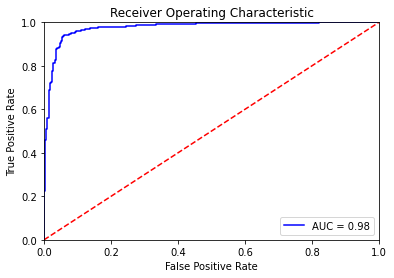

Optimal Threshold obtained using difference of TPR and FPR 0.65226674


In [ ]:
fpr, tpr , thresholds = roc_curve(y, data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

##Training logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_scores = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_scores)

0.7950474816684697

##Training Naive Bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.7655968265416516

##Training RandomForestClassifer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.7866330087750931

In [ ]:
independent_columns = list(X)
background = sklearn.utils.resample(X, n_samples=100, replace=True)
explainer = shap.TreeExplainer(model, feature_dependence='independent', model_output='probability')
shap_values =  explainer.shap_values(X)
shap_df1 = pd.DataFrame(shap_values, columns=X.columns)
#shap_df1.to_csv(shap_file_name, index = False)
print(shap_values.shape)

(1000, 59)


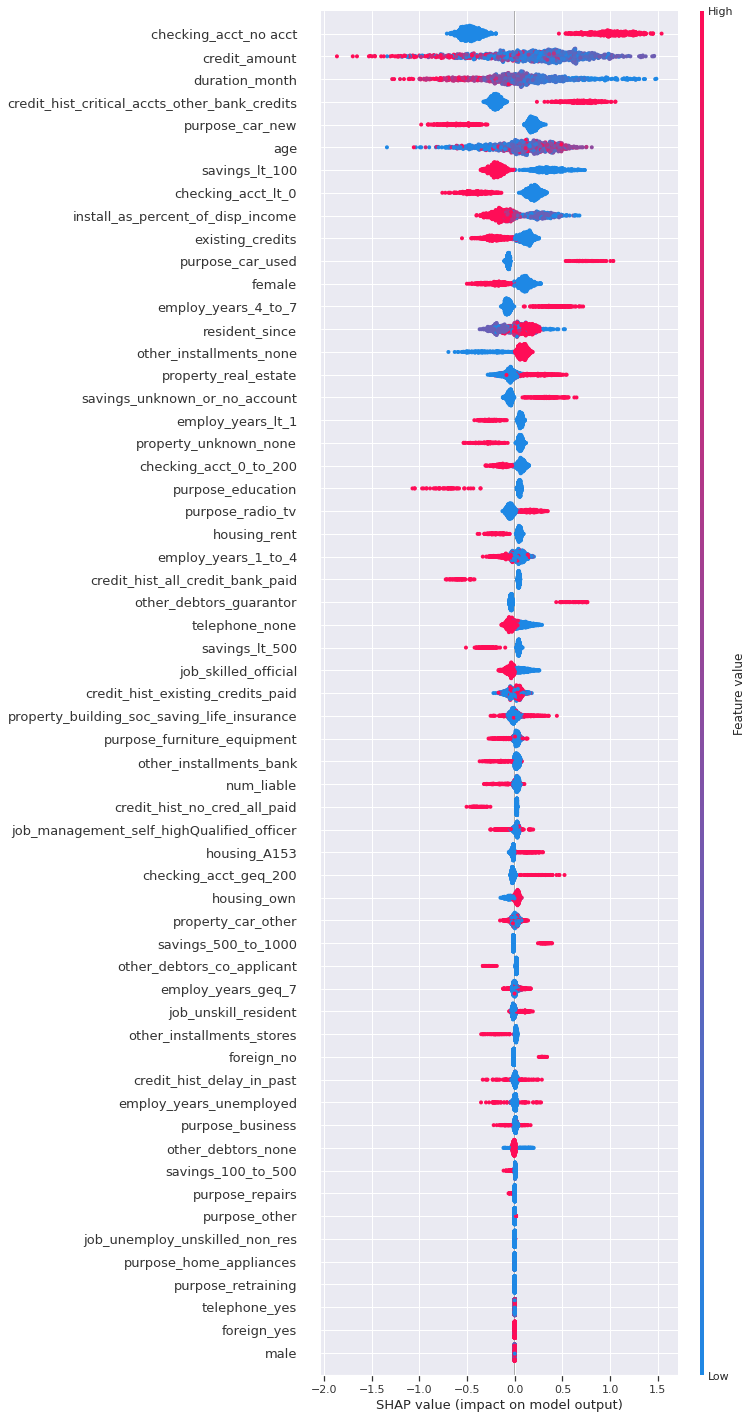

In [ ]:
sns.set()
shap.summary_plot(shap_values, X,  max_display = 59)

Negative SHAP values for high value of female indicate bias based on sex

Randomize female attribue

In [ ]:
data_final['female_random'] = np.random.permutation(data_final['female'])

np.sum(data_final['female_random']==data_final['female'])

556

Keep sex and random sex columns both

[0]	test-auc:0.704592
[1000]	test-auc:0.914172
[2000]	test-auc:0.944825
[3000]	test-auc:0.963457
[4000]	test-auc:0.978603
[5000]	test-auc:0.98858
[6000]	test-auc:0.99423
[7000]	test-auc:0.996394
[8000]	test-auc:0.998678
[9000]	test-auc:0.999639
[9999]	test-auc:1


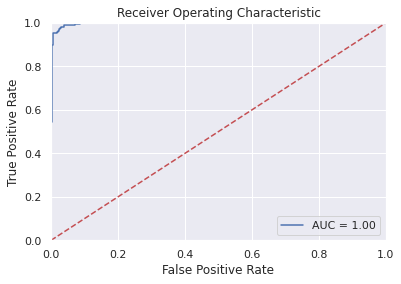

Optimal Threshold obtained using difference of TPR and FPR 0.6085302


In [ ]:
X_r =  data_final.drop(columns=['ground_truth','married_and_sex_male_div_sep','married_and_sex_female_div_sep_married','married_and_sex_male_single','married_and_sex_male_married_widowed','pred','y_pred'])
y =  data_final.loc[:, 'ground_truth']
X_train, X_test, y_train, y_test = train_test_split(X_r, y, test_size =  0.2, random_state =  4)

xgb_full = xgboost.DMatrix(X_r, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
data_final['pred'] = model.predict(xgb_full)

fpr, tpr , thresholds = roc_curve(y, data_final['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

explainer = shap.TreeExplainer(model)
shap_values =  explainer.shap_values(X_r)

In [ ]:
shap_values =  explainer.shap_values(X_r)

In [ ]:
print(shap_values.shape)

(1000, 60)


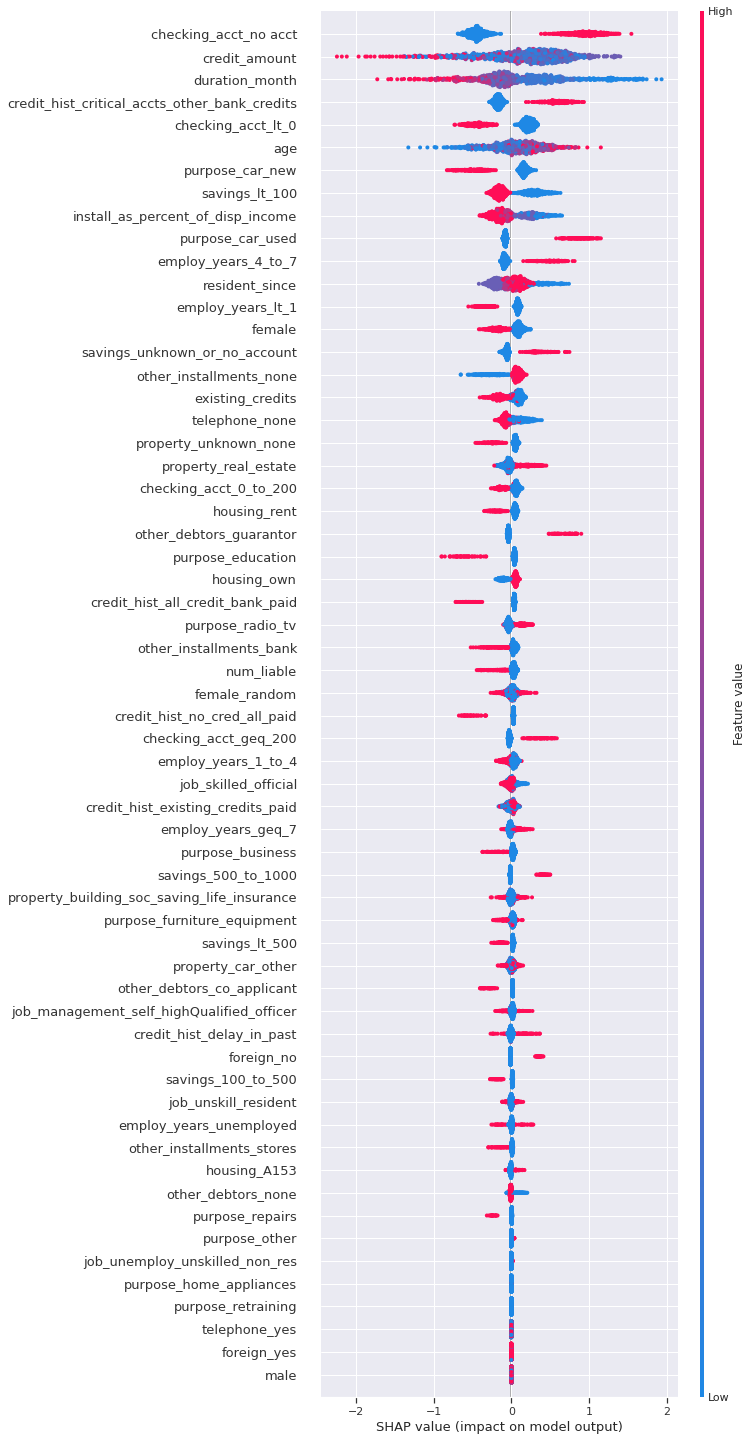

In [ ]:
sns.set()
shap.summary_plot(shap_values, X_r, max_display=60)

Female_random attribute now showing both positive and negative SHAP values for being female. This is how it should be. 

# General Distribution for Sex and  Randomized Sex

In [ ]:
sex_female = data_final[(data_final['female']==1)].index
sex_male = data_final[(data_final['female']==0)].index

print("Number of Females  is " + str(len(sex_female)))
print("Number of Males  is " + str(len(sex_male)))

location_female  =  X_r.columns.get_loc("female")
location_male =X_r.columns.get_loc("male")
location_rand = X_r.columns.get_loc("female_random")

Number of Females  is 310
Number of Males  is 690


In [ ]:
locations_interested = [location_female,location_male, location_rand]

In [ ]:
def get_pmf(data, num_bins = 100):
  counts, bins = np.histogram(data ,bins=num_bins)
  bins = bins[:-1] + (bins[1] - bins[0])/2
  probs = counts/float(counts.sum())
  return probs

KL Divergence of the two distributions 1.1898658659834271
KL Divergence of the two distributions 1.451452706212343


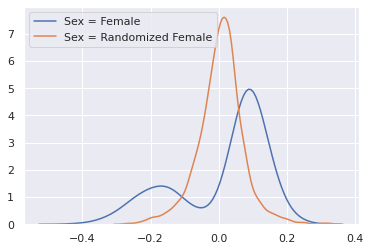

In [ ]:
sns.kdeplot(shap_values[:, location_female], label = 'Sex = Female')
sns.kdeplot(shap_values[:, location_rand], label = 'Sex = Randomized Female')

pmf_rand =  get_pmf(shap_values[:, location_rand])
pmf_orig =  get_pmf(shap_values[:, location_female])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

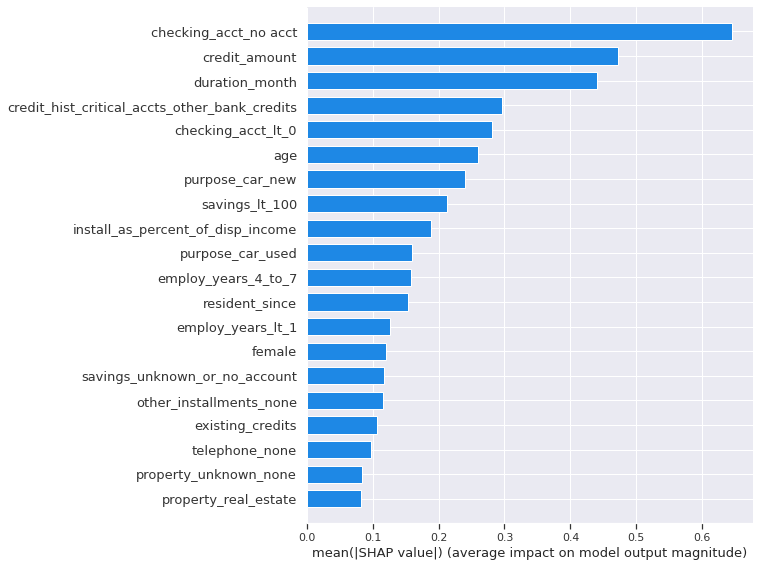

In [ ]:
shap.summary_plot(shap_values, X_r, plot_type="bar")

# Separation or Equalized Odds

In [ ]:
Y_1_F =  data_final[(data_final['ground_truth']==1) & (data_final['female']==1)].index
Y_1_M = data_final[(data_final['ground_truth']==1) & (data_final['female']==0)].index

Y_1_F_random =  data_final[(data_final['ground_truth']==1) & (data_final['female_random']==1)].index
Y_1_M_random = data_final[(data_final['ground_truth']==1) & (data_final['female_random']==0)].index



Y_0_F =  data_final[(data_final['ground_truth']==0) & (data_final['female']==1)].index
Y_0_M = data_final[(data_final['ground_truth']==0) & (data_final['female']==0)].index

Y_0_F_random =  data_final[(data_final['ground_truth']==0) & (data_final['female_random']==1)].index
Y_0_M_random = data_final[(data_final['ground_truth']==0) & (data_final['female_random']==0)].index
print("Should decrease number of females with poor credit and increase number of males with poor credit")
print("Number of Y=0 instances given female: " + str(len(Y_0_F)))
print("Number of Y=0 instances given male: " + str(len(Y_0_M)))
print("Number of Y=0 instances given female_random: " + str(len(Y_0_F_random)))
print("Number of Y=0 instances given male_random: " + str(len(Y_0_M_random)))
print()

print("Should increase number of females with good credit and decrease number of males with good credit")
print("Number of Y=1 instances given female: " + str(len(Y_1_F)))
print("Number of Y=1 instances given male: " + str(len(Y_1_M)))
print("Number of Y=1 instances given female_random: " + str(len(Y_1_F_random)))
print("Number of Y=1 instances given male_random: " + str(len(Y_1_M_random)))

Should decrease number of females with poor credit and increase number of males with poor credit
Number of Y=0 instances given female: 109
Number of Y=0 instances given male: 191
Number of Y=0 instances given female_random: 93
Number of Y=0 instances given male_random: 207

Should increase number of females with good credit and decrease number of males with good credit
Number of Y=1 instances given female: 201
Number of Y=1 instances given male: 499
Number of Y=1 instances given female_random: 217
Number of Y=1 instances given male_random: 483


In [ ]:
X=X_r #Hack here
X_set =  X.iloc[Y_0_F]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_female_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_M]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_male_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_0_F_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_female_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_0_M_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_0_male_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

KL Divergence of the two distributions 0.6660642673423242
KL Divergence of the two distributions 0.7658405115842241


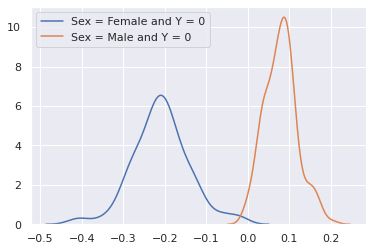

In [ ]:
sns.kdeplot(y_0_female_values[:,0], label = 'Sex = Female and Y = 0')
sns.kdeplot(y_0_male_values[:,0], label = 'Sex = Male and Y = 0')
pmf_rand =  get_pmf(y_0_female_values[:,0])
pmf_orig =  get_pmf(y_0_male_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

Equality of opportunity requires that the distribution of SHAP values of the protected attribute for true advantageous outcome (Y=1) should be similar. These distributions have a fairly high KL divergence and so are dissimilar.

Equalized Odds requires that given a particular true outcome (Y=0 or Y=1), the SHAP explanation for the protected attribute should be similar for different protected classes. 

KL Divergence of the two distributions 0.7774095012405224
KL Divergence of the two distributions 0.8782759364442692


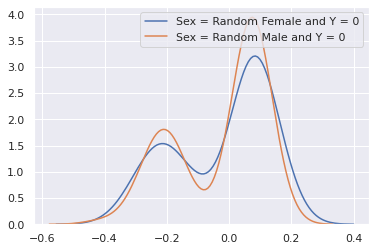

In [ ]:
sns.kdeplot(y_0_female_random_values[:,0], label = 'Sex = Random Female and Y = 0')
sns.kdeplot(y_0_male_random_values[:,0], label = 'Sex = Random Male and Y = 0')

pmf_rand =  get_pmf(y_0_female_random_values[:,0])
pmf_orig =  get_pmf(y_0_male_random_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

# Equality of Opportunity

In [ ]:
X_set =  X.iloc[Y_1_F]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_female_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_M]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_male_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

X_set =  X.iloc[Y_1_F_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_female_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)


X_set =  X.iloc[Y_1_M_random]
shap_values_set =  explainer.shap_values(X_set)
#shap.summary_plot(shap_values_set, X_set, sort = False)
y_1_male_random_values =  shap_values_set[:, locations_interested]
#plt.hist(tpr_val, bins = 20)

KL Divergence of the two distributions 0.442521025451327
KL Divergence of the two distributions 0.6045308752660923


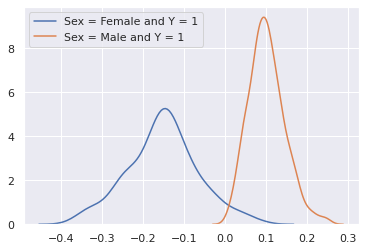

In [ ]:
sns.kdeplot(y_1_female_values[:,0], label = 'Sex = Female and Y = 1')
sns.kdeplot(y_1_male_values[:,0], label = 'Sex = Male and Y = 1')
pmf_rand =  get_pmf(y_1_female_values[:,0])
pmf_orig =  get_pmf(y_1_male_values[:,0])
print("KL Divergence of the two distributions " + str(entropy(pmf_rand + 0.001, pmf_orig +0.001)))
print("KL Divergence of the two distributions " + str(entropy(pmf_orig + 0.001, pmf_rand +0.001)))

#Recourse

In [ ]:
shap_df = pd.DataFrame(shap_values, columns =X.columns)
shap_df.head()

,duration_month,credit_amount,install_as_percent_of_disp_income,resident_since,age,existing_credits,num_liable,checking_acct_0_to_200,checking_acct_geq_200,checking_acct_lt_0,checking_acct_no acct,credit_hist_all_credit_bank_paid,credit_hist_critical_accts_other_bank_credits,credit_hist_delay_in_past,credit_hist_existing_credits_paid,credit_hist_no_cred_all_paid,purpose_business,purpose_car_new,purpose_car_used,purpose_education,purpose_furniture_equipment,purpose_home_appliances,purpose_other,purpose_radio_tv,purpose_repairs,purpose_retraining,savings_100_to_500,savings_500_to_1000,savings_lt_100,savings_lt_500,savings_unknown_or_no_account,employ_years_1_to_4,employ_years_4_to_7,employ_years_geq_7,employ_years_lt_1,employ_years_unemployed,other_debtors_co_applicant,other_debtors_guarantor,other_debtors_none,property_building_soc_saving_life_insurance,property_car_other,property_real_estate,property_unknown_none,other_installments_bank,other_installments_none,other_installments_stores,housing_A153,housing_own,housing_rent,job_management_self_highQualified_officer,job_skilled_official,job_unemploy_unskilled_non_res,job_unskill_resident,telephone_none,telephone_yes,foreign_no,foreign_yes,female,male,female_random
0,1.572198,0.644815,-0.053548,0.124891,0.466986,-0.084228,0.046085,0.053234,-0.003595,-0.467192,-0.444156,0.044822,0.780479,0.010029,-0.034036,0.033447,0.016919,0.128101,-0.051976,0.040105,-0.005061,0.000042,-0.000594,0.137306,0.008460,0.0,0.010723,-0.012536,0.213793,0.020965,0.219715,0.038598,-0.052189,0.090986,0.072228,0.002528,0.013081,-0.034330,-0.012065,-0.009916,0.023519,0.253547,0.095465,0.021570,0.100948,0.020216,0.000837,0.079308,0.025342,0.033864,-0.019092,-0.000405,-0.010942,0.212442,0.0,-0.010178,0.0,0.083738,0.0,0.068418
1,-1.584571,0.366433,0.269115,-0.206481,-0.776632,0.150342,0.005353,-0.144194,-0.036690,0.238410,-0.448215,0.028024,-0.098703,-0.038528,-0.047433,0.021564,0.012190,0.116196,-0.089275,0.029436,0.030187,0.000016,-0.000749,-0.049904,0.005403,0.0,0.009564,-0.017797,-0.220823,0.026180,-0.112062,-0.091289,-0.087362,-0.032583,0.086156,-0.008850,0.017382,-0.044978,-0.008078,0.011066,-0.020799,0.000395,0.031630,0.024877,0.046710,0.001871,-0.023446,0.023386,0.056233,0.016690,-0.047503,-0.000392,-0.023162,0.026338,0.0,-0.010363,0.0,-0.216204,0.0,-0.044806
2,0.443066,0.385823,0.295192,0.021502,0.683274,0.057305,-0.203853,0.064812,-0.005396,0.165283,0.849734,0.040569,0.576942,0.019285,-0.054179,0.030679,0.035241,0.093789,-0.066593,-0.739308,0.052972,0.000042,-0.000679,-0.056815,0.008633,0.0,0.012094,-0.012144,-0.141399,0.012653,-0.061965,0.003804,0.578104,0.015418,0.103683,0.006339,0.018545,-0.029874,-0.000063,0.022024,-0.035561,0.117128,0.052821,0.048223,0.138004,0.019985,-0.003109,0.018909,0.024971,0.030575,0.030260,-0.000333,0.032737,-0.104291,0.0,-0.010148,0.0,0.066486,0.0,0.009525
3,-0.270144,-0.154538,0.382164,-0.007177,0.225932,0.089206,-0.020679,0.063628,-0.035424,-0.503389,-0.462495,0.037587,-0.140750,-0.028613,0.000341,0.023655,0.026460,0.147741,-0.080870,0.023301,-0.044101,0.000009,-0.000722,-0.016084,0.006095,0.0,0.007226,-0.014330,-0.146465,0.017523,-0.067577,0.040547,0.460927,0.035346,0.076144,-0.028308,0.017159,0.698622,0.099672,0.036982,0.014463,-0.042064,0.064891,0.025660,0.049820,0.007312,0.097039,-0.083062,0.055315,-0.032323,-0.133497,-0.000338,-0.014443,-0.030723,0.0,-0.010288,0.0,0.038028,0.0,0.008752
4,-0.159066,-0.164682,-0.135358,-0.038816,-0.370246,-0.236288,-0.101916,0.017582,-0.036788,-0.562009,-0.507535,0.038071,-0.282205,0.179549,-0.021912,0.029539,0.028691,-0.339018,-0.099819,0.023146,-0.019191,0.000009,-0.000794,-0.032791,0.006089,0.0,0.008322,-0.015283,-0.170094,0.014009,-0.068947,-0.006227,-0.095705,0.029840,0.079408,-0.027667,0.013760,-0.048029,-0.014050,0.003549,-0.000841,-0.064525,-0.242816,0.002766,0.060623,0.008634,0.076332,-0.119021,0.053179,-0.023670,-0.090826,-0.000376,-0.016025,-0.077087,0.0,-0.011843,0.0,0.038445,0.0,0.017805


In [ ]:
## Creating the dataset for compas values
data_final['id'] =  np.arange(0, data_final.shape[0])
shap_sex = (shap_values[:, location_female])
group = X.iloc[:, location_female]
label = data_final['ground_truth']
pred =  data_final['pred']
id = data_final['id']

data_recourse = pd.DataFrame({'id':id, 'shap':shap_sex,'label':label,'group':group, 'prediction':pred})

#data_final.head()
data_recourse.head()

,id,shap,label,group,prediction
0,0,0.083738,1,0,0.994628
1,1,-0.216204,0,1,0.103103
2,2,0.066486,1,0,0.987608
3,3,0.038028,1,0,0.773231
4,4,0.038445,0,0,0.059826


Parts of the code below are adopted from the  code for the papers One Fairness and Calibration 
https://github.com/gpleiss/equalized_odds_and_calibration

In [ ]:
class Model(namedtuple('Model', 'id shap pred label')):
  
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        #jump
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Model(self.id, self.shap, pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate, w_fp = 1, w_fn = 1):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(w_fp *fp_rate + w_fn *fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = w_fp*fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            w_fn*fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res
    
    def calib_eq_odds(self, other, fp_rate, fn_rate, shap_enabled =  False, mix_rates=None):
        if mix_rates is None:
          if fn_rate == 0:
              self_cost = self.fp_cost()
              other_cost = other.fp_cost()
              print(self_cost, other_cost)
              self_trivial_cost = self.trivial().fp_cost()
              other_trivial_cost = other.trivial().fp_cost()
          elif fp_rate == 0:
              self_cost = self.fn_cost()
              other_cost = other.fn_cost()
              self_trivial_cost = self.trivial().fn_cost()
              other_trivial_cost = other.trivial().fn_cost()
          else:
              w_fp =1
              w_fn =1
              self_cost = self.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_cost = other.weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)
              other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate, w_fp, w_fn)

  #         print("The costs are ", self_cost, other_cost, self_trivial_cost, other_trivial_cost)
          other_costs_more = other_cost > self_cost
          self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
          other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)
          print("The mix_rates are ", self_mix_rate, other_mix_rate)
        else:
          self_mix_rate = mix_rates[0]
          other_mix_rate = mix_rates[1]
        # New classifiers
        
#         self_indices = np.random.permutation(len(self.pred))[:int(self_mix_rate * len(self.pred))]
#         self_new_pred = self.pred.copy()
#         self_new_pred[self_indices] = self.base_rate()
#         calib_eq_odds_self = Model(self.id, self.shap, self_new_pred, self.label)

#         print("Running the post processing for group 0 ")
        if shap_enabled:
          self_changed_id, self_new_pred = self.shap_fair_individuals_calibrated(self_mix_rate, advantaged  = True)
        else:
          self_changed_id, self_new_pred = self.randomized_fair_individuals_calibrated(self_mix_rate)
        
        
       
          
        calib_eq_odds_self = Model(self_changed_id, self.shap, self_new_pred, self.label)
        
        if self_mix_rate >0:
          print("Changing SELF Model--------------- for self mix rate ", self_mix_rate)
#           print(self_changed_id)
          df = self.get_pandas_df()
#           print(df.head(2))
#           df.loc[self_changed_id,'pred'].hist()
#           plt.title('Prediction')
#           plt.show()
          
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=self.base_rate(), color='r', linestyle='-')
          plt.title("Choosing " +str(len(self_changed_id)) + " Individuals from " + str(len(self_changed_id)) + "individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(self_new_pred==self.pred))


#         other_indices = np.random.permutation(len(other.pred))[:int(other_mix_rate * len(other.pred))]
#         other_new_pred = other.pred.copy()
#         other_new_pred[other_indices] = other.base_rate()
#         calib_eq_odds_other = Model(other.id, other.shap, other_new_pred, other.label)

        if shap_enabled:
          other_changed_id, other_new_pred = other.shap_fair_individuals_calibrated(other_mix_rate, advantaged = False)
        else:
          other_changed_id, other_new_pred = other.randomized_fair_individuals_calibrated(other_mix_rate)
        sns.set(rc={'figure.figsize':(5.7,5.27)})

        
          
        calib_eq_odds_other = Model(other_changed_id, other.shap, other_new_pred, other.label)
    
        if other_mix_rate >0:
          print("Changing Other Model--------------- for other mix rate ", other_mix_rate)
#           print(other_changed_id)
          df = other.get_pandas_df()
#           print(df.head(2))
#           df.loc[other_changed_id,'pred'].hist()
#           plt.title('Prediction Distribution')
#           plt.show()
    
#           df.loc[other_changed_id,'shap'].hist()
#           plt.title('SHAp Value Distribution')

#           plt.show()
#           sns.scatterplot(x =df.loc[other_changed_id,'shap'], y= df.loc[other_changed_id,'pred'])
#           plt.title('')
#           plt.axhline(y=other.base_rate(), color='r', linestyle='-')

#           plt.show()
          sns.set(rc={'figure.figsize':(12.7,8.27)})
          df.plot.scatter(x ='shap', y='pred')
          plt.axhline(y=other.base_rate(), color='g', linestyle='--', linewidth = 5)
          plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)
          plt.xlim(-0.1, 0.1)
          plt.title("Need to choose " +str(len(other_changed_id)) + " people from " + str(len(other.shap)) + " individuals")
          plt.show()
        else:
          print("Number of people with equal predictions in self " , np.sum(other_new_pred==other.pred))
        

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other
          
    def shap_fair_individuals_calibrated(self, mix_rate , advantaged):
        total = len(self.id)
        num_changed =int(mix_rate * total)
        df = self.get_pandas_df()
        print("In SHAP Method Number of people changed %d and total number %d " % (num_changed, total) )

        base_rate = self.base_rate()
        if advantaged:
          if mix_rate > 0:
            print("Redistributing Predictions for Advantaged Group")
            
          

            

#           df['except_race'] =  df['pred'] - df['shap']
          changed_indices = df.sort_values('shap', ascending = False).index[:num_changed]
#           changed_indices = df.sort_values('except_race', ascending = False).index[:num_changed]

          df.loc[changed_indices, 'pred'] = self.base_rate()
  #         print("After changning pred value")
  #         print(df.head())
        else:
          if mix_rate > 0:
            print("Redistributing Predictions for Dis Advantaged Group")
            
          quadrant_1 = df[(df['shap'] > 0) & (df['pred'] > base_rate)].index
          quadrant_2 = df[(df['shap'] < 0) & (df['pred'] > base_rate)].index
          quadrant_3 = df[(df['shap'] <= 0) & (df['pred'] <= base_rate)].index
          quadrant_4 = df[(df['shap'] >= 0)& (df['pred'] <= base_rate)].index
          df['distance'] =  np.sqrt(np.square(df['shap']) + np.square(df['pred'] - base_rate))  
          print("Number of people in each quadrant ", len(quadrant_1),len(quadrant_2),len(quadrant_3),len(quadrant_4))
          
          required_changed_ids = num_changed
          print(required_changed_ids)
          changed_indices1 = (list(df.loc[(quadrant_1.union(quadrant_3))].sort_values('distance', ascending = False).index[:required_changed_ids]))
          print("People taken from Quadrant 1 and 3 ", len(changed_indices1))
          required_changed_ids -= len(changed_indices1)
          print("ID 's left to take  Adfter Quadrant 1 and 3 ", required_changed_ids)
          changed_indices2 = list(df.loc[quadrant_2.union(quadrant_4)].sort_values('distance', ascending = True).index[:required_changed_ids])
          required_changed_ids -= len(changed_indices2)
          print("Number of ids changed in the end ", len(changed_indices2))
          changed_indices = changed_indices1+ changed_indices2
            
          #changed_indices = df.sort_values('shap', ascending = True).index[:num_changed]
          
          
          df.loc[changed_indices, 'pred'] = self.base_rate()
          

          

        return changed_indices, df.pred.copy()
    
    
    
    def randomized_fair_individuals_calibrated(self, mix_rate):
        total = len(self.id)
        changed_indices = np.random.permutation(self.id)[:int(mix_rate * total)]
#         print("In randmoized Number of people changed %d and total number %d " % (len(changed_indices), total) ) 
      
        df = self.get_pandas_df()
        
        df.loc[changed_indices, 'pred'] = self.base_rate()
#         print("After changning pred value")
#         print(df.loc[changed_indices].head(10))
# 
        return changed_indices, df.pred.copy() 

    def randomized_fair_individuals_equalized(self, p2p, n2p):
        from sklearn.utils import shuffle

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos =  shuffle(original_pos)     
        p2n_indices = original_pos.head(no_p2n).index
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        n2p_indices = original_neg.head(no_n2p).index
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()

    def shap_fair_individuals_equalized(self, p2p, n2p):

        df = self.get_pandas_df()
        df['pred_outcome'] = df['pred'].round()
        original_pos =  df[df['pred_outcome'] == 1]
        # Changing positive predictions
        # Flipping positive predictions for people with lowest prediction without their race
        no_p2n= int(original_pos.shape[0] *  (1 - p2p))
        original_pos['pred_except_race_shap'] = original_pos['pred']-original_pos['shap']
        p2n_indices = np.asarray(original_pos.sort_values('pred_except_race_shap', ascending = True).index[:no_p2n])
        df.loc[p2n_indices, 'pred'] = 1 - df.loc[p2n_indices, 'pred']      
        
        #Changing negative predictions
        # Flipping Negative Predictions for people with highest contribution except SHAP
        original_neg = df[df['pred_outcome']==0]
        no_n2p= int(original_neg.shape[0] *  (n2p))
        original_neg['pred_except_race_shap'] = original_neg['pred']-original_neg['shap']
        n2p_indices = np.asarray(original_neg.sort_values('pred_except_race_shap', ascending = False).index[:no_n2p])
        df.loc[n2p_indices, 'pred'] = 1 - df.loc[n2p_indices, 'pred']      

        changed_ids = np.append(n2p_indices, p2n_indices)
        return changed_ids, df.pred.copy()
    
    def get_pandas_df(self):
        a = pd.DataFrame({'id':self.id, 'shap':self.shap,'label':self.label, 'pred':self.pred})
        a.set_index('id', inplace =  True)
        return a
        
    def get_changed_id(self):
      return self.id

    def eq_odds(self, other, shap_enabled =  False, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(other)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        print("sp2p, sn2p, op2p, on2p ", sp2p, sn2p, op2p, on2p)
#         self_fair_pred = self.pred.copy()
        ## Original Positive Predictions
#         self_pp_indices, = np.nonzero(self.pred.round())        
        ## Original Negative Predictions
#         self_pn_indices, = np.nonzero(1 - self.pred.round())
        
        
#         np.random.shuffle(self_pp_indices)
#         np.random.shuffle(self_pn_indices)
        
        
#         print("Self Negative to Postive Rate ", sn2p)
#         #print("Self Postive Indices Shuffled ", self_pp_indices[:5])
        
#         self_n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
#         print("Length of self n2p indices ", len(self_n2p_indices))
#         #print("Before ", self_fair_pred)
#         self_fair_pred[self_n2p_indices] = 1 - self_fair_pred[self_n2p_indices]
#         #print("After ", self_fair_pred)
        
#         print("Self Positive to Negative Rate ", 1 - sp2p)
                
#         self_p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
#         print("Length of self p2n indices ", len(self_p2n_indices))

#         #print("Before ", self_fair_pred[self_p2n_indices])

#         self_fair_pred[self_p2n_indices] = 1 - self_fair_pred[self_p2n_indices]
#         #print("After ", self_fair_pred[self_p2n_indices])
#         self_changed_id =  np.append(self_p2n_indices, self_n2p_indices)
        df_self = self.get_pandas_df()
        if shap_enabled:
           print("using SHAP based selection of individuals for self ")
           self_changed_id, self_fair_pred = self.shap_fair_individuals_equalized(sp2p, sn2p)
      
        else:
          print("using random based selection of individuals for self ")
          self_changed_id, self_fair_pred = self.randomized_fair_individuals_equalized(sp2p, sn2p)

        df_self.loc[self_changed_id, 'pred'].hist()
        plt.show()
        df_self.loc[self_changed_id, 'shap'].hist()
        plt.show()
#         othr_fair_pred = othr.pred.copy()
#         othr_pp_indices, = np.nonzero(othr.pred.round())
#         othr_pn_indices, = np.nonzero(1 - othr.pred.round())
#         np.random.shuffle(othr_pp_indices)
#         np.random.shuffle(othr_pn_indices)
#         print("Other Negative to Postive Rate ", on2p)

#         other_n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
#         print("Length of Other n2p indices ", len(other_n2p_indices))

        
#         othr_fair_pred[other_n2p_indices] = 1 - othr_fair_pred[other_n2p_indices]

#         print("Other Negative to Postive Rate ", 1 - op2p)
        
#         other_p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
#         print("Length of Other p2n indices ", len(other_p2n_indices))

#         othr_fair_pred[other_p2n_indices] = 1 - othr_fair_pred[other_p2n_indices]
#         other_changed_id =  np.append(other_p2n_indices, other_n2p_indices)
#         print("Lengths of total other changed ids ", len(other_changed_id))
        df_other =  other.get_pandas_df()
        if shap_enabled:
          print("using SHAP based selection of individuals for other ")
          other_changed_id, other_fair_pred = other.shap_fair_individuals_equalized(op2p,on2p)
        else:
          print("using  random selection of individuals for other ")
          other_changed_id, other_fair_pred = other.randomized_fair_individuals_equalized(op2p,on2p)
        df_other.loc[other_changed_id,'pred'].hist()
        plt.show()

        df_other.loc[other_changed_id,'shap'].hist()
        plt.show()

        fair_self = Model(self_changed_id, self.shap, self_fair_pred, self.label)
        fair_other = Model(other_changed_id, other.shap, other_fair_pred, other.label)
  
        
        if not has_mix_rates:
            return fair_self, fair_other, mix_rates
        else:
            return fair_self, fair_other

          
          
    def eq_odds_optimal_mix_rates(self, othr):
      
        """Function to calculate mix rates for equalized odds"""
        np.random.seed(34)
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

      

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [ ]:
""# Cost constraint
cost_constraint = 'weighted'

if cost_constraint == 'fnr':
    fn_rate = 1
    fp_rate = 0
elif cost_constraint == 'fpr':
    fn_rate = 0
    fp_rate = 1
elif cost_constraint == 'weighted':
    fn_rate = 1
    fp_rate = 1
    
    
test_and_val_data = data_recourse
print(test_and_val_data.head())

# Randomly split the data into two sets - one for computing the fairness constants
np.random.seed(42)
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]


# Create model objects - one for each group, validation and test
group_0_val_data = val_data[val_data['group'] == 0]
group_1_val_data = val_data[val_data['group'] == 1]
group_0_test_data = test_data[test_data['group'] == 0]
group_1_test_data = test_data[test_data['group'] == 1]

#print(group_0_val_data.head())
#print(group_1_val_data.head())
#print(group_0_test_data.head())
#print(group_1_test_data.head())



group_0_val_model = Model(group_0_val_data['id'].to_numpy(),group_0_val_data['shap'].to_numpy(), group_0_val_data['prediction'].to_numpy(), 
                          group_0_val_data['label'].to_numpy())
group_1_val_model = Model(group_1_val_data['id'].to_numpy(), group_1_val_data['shap'].to_numpy(), group_1_val_data['prediction'].to_numpy(),
                          group_1_val_data['label'].to_numpy())
group_0_test_model = Model(group_0_test_data['id'].to_numpy(), group_0_test_data['shap'].to_numpy(), group_0_test_data['prediction'].to_numpy(), 
                           group_0_test_data['label'].to_numpy())
group_1_test_model = Model(group_1_test_data['id'].to_numpy(), group_1_test_data['shap'].to_numpy(), group_1_test_data['prediction'].to_numpy(), 
                           group_1_test_data['label'].to_numpy())

   id      shap  label  group  prediction
0   0  0.083738      1      0    0.994628
1   1 -0.216204      0      1    0.103103
2   2  0.066486      1      0    0.987608
3   3  0.038028      1      0    0.773231
4   4  0.038445      0      0    0.059826


# Equalized Odds as described by paper Equality of Opportunity in Supervised Learning

sp2p, sn2p, op2p, on2p  [0.95704024] [3.68804287e-09] [1.] [0.08194432]
using random based selection of individuals for self 


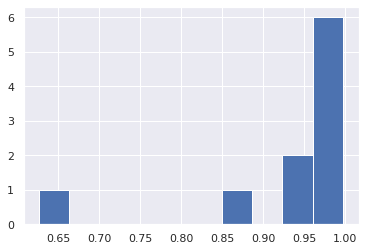

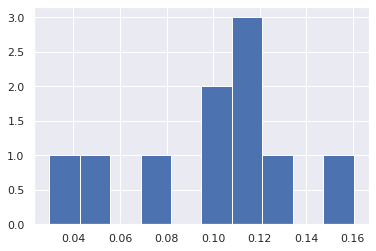

using  random selection of individuals for other 


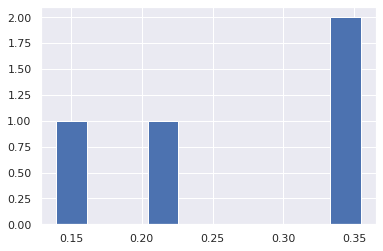

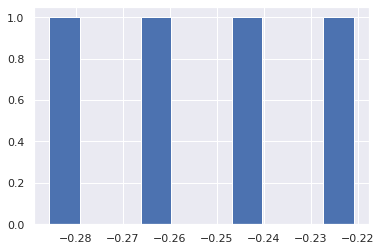

------------------Calculating mix_Rates for test models--------------------------------
sp2p, sn2p, op2p, on2p  [0.95704024] [3.68804287e-09] [1.] [0.08194432]
using random based selection of individuals for self 


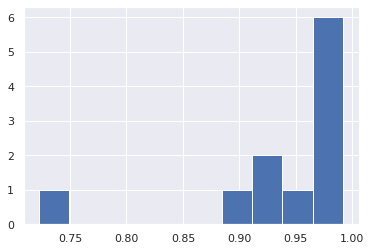

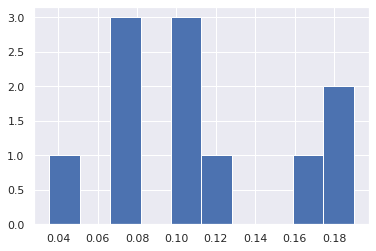

using  random selection of individuals for other 


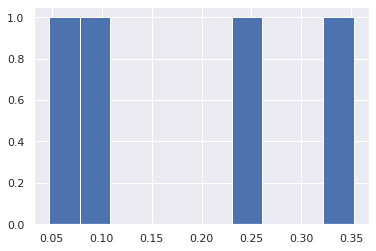

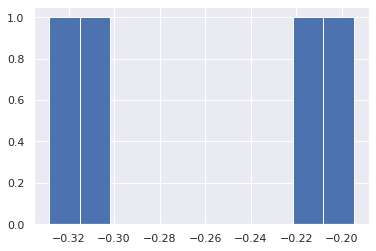

Original group 0 model:
Accuracy:	0.966
F.P. cost:	0.247
F.N. cost:	0.104
Base rate:	0.735
Avg. score:	0.724

Original group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633

Equalized odds group 0 model:
Accuracy:	0.935
F.P. cost:	0.247
F.N. cost:	0.141
Base rate:	0.735
Avg. score:	0.697

Equalized odds group 1 model:
Accuracy:	0.952
F.P. cost:	0.269
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.650



In [ ]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, False,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

sp2p, sn2p, op2p, on2p  [0.95704024] [3.68804287e-09] [1.] [0.08194432]
using SHAP based selection of individuals for self 


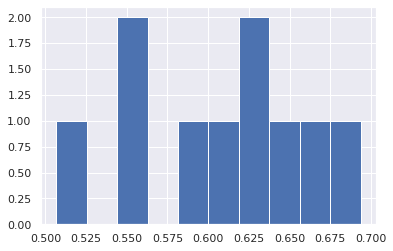

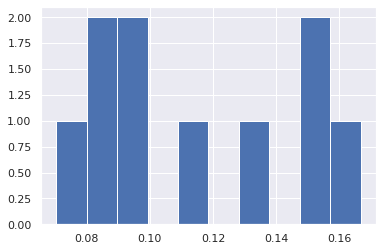

using SHAP based selection of individuals for other 


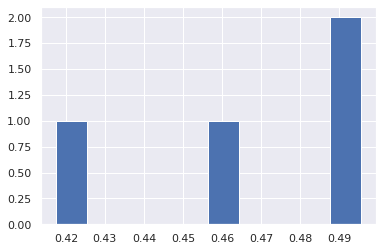

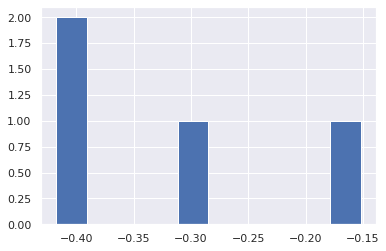

------------------Calculating mix_Rates for test models--------------------------------
[[9.57040240e-01]
 [3.68804287e-09]
 [9.99999998e-01]
 [8.19443166e-02]]
sp2p, sn2p, op2p, on2p  [0.95704024] [3.68804287e-09] [1.] [0.08194432]
using SHAP based selection of individuals for self 


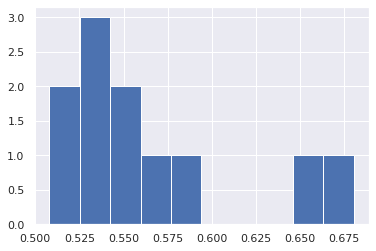

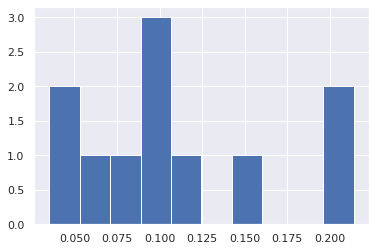

using SHAP based selection of individuals for other 


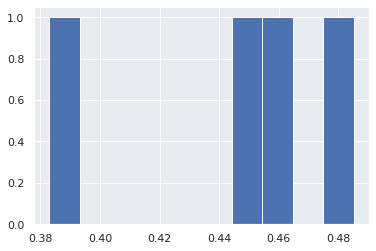

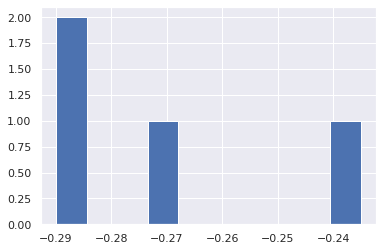

Original group 0 model:
Accuracy:	0.966
F.P. cost:	0.247
F.N. cost:	0.104
Base rate:	0.735
Avg. score:	0.724

Original group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633

Equalized odds group 0 model:
Accuracy:	0.963
F.P. cost:	0.243
F.N. cost:	0.108
Base rate:	0.735
Avg. score:	0.720

Equalized odds group 1 model:
Accuracy:	0.952
F.P. cost:	0.232
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.636



In [ ]:
_, _, mix_rates_eq = Model.eq_odds(group_0_val_model, group_1_val_model, True)

print("------------------Calculating mix_Rates for test models--------------------------------")
# Apply the mixing rates to the test models
print(mix_rates_eq)
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                     group_1_test_model, True,
                                                                     mix_rates_eq)

# Print results on test model
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))

print('Equalized odds group 0 model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group 1 model:\n%s\n' % repr(eq_odds_group_1_test_model))

# Calibrated Equalized Odds

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0.04687490373910556 0
Changing SELF Model--------------- for self mix rate  0.04687490373910556


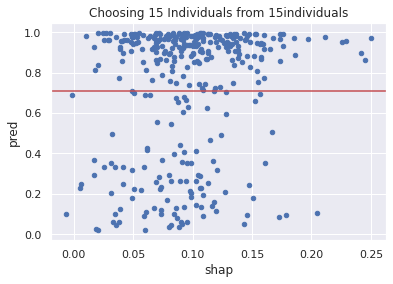

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Number of people with equal predictions in self  165

---------------Calculated Mix Rates and Applying to test models-----------

Changing SELF Model--------------- for self mix rate  0.04687490373910556


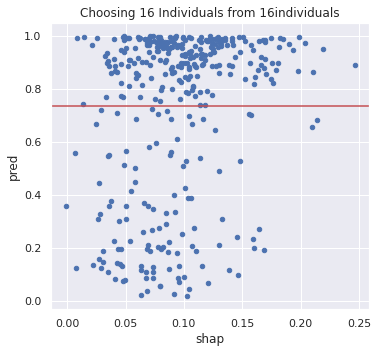

Number of people with equal predictions in self  145

Original group 0 model:
Accuracy:	0.966
F.P. cost:	0.247
F.N. cost:	0.104
Base rate:	0.735
Avg. score:	0.724

Original group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633

Randomized Calibrated Equalized odds group 0 model:
Accuracy:	0.955
F.P. cost:	0.274
F.N. cost:	0.113
Base rate:	0.735
Avg. score:	0.725

Randomized Calibrated Equalized odds group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633



In [ ]:
# Find mixing rates for equalized odds models
_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate)

# Apply the mixing rates to the test models

print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,False,
                                                                                         mix_rates)




# Print results on test model

print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('Randomized Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
print('Randomized Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The mix_rates are  0.04687490373910556 0
In SHAP Method Number of people changed 15 and total number 335 
Redistributing Predictions for Advantaged Group
Changing SELF Model--------------- for self mix rate  0.04687490373910556


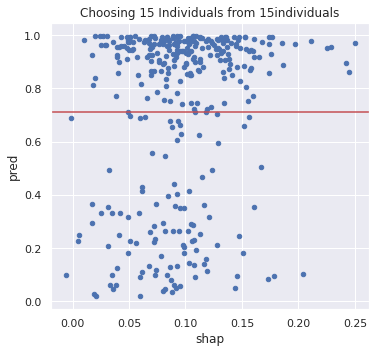

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In SHAP Method Number of people changed 0 and total number 165 
Number of people in each quadrant  6 99 59 1
0
People taken from Quadrant 1 and 3  0
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Number of people with equal predictions in self  165

---------------Calculated Mix Rates and Applying to test models-----------

In SHAP Method Number of people changed 16 and total number 355 
Redistributing Predictions for Advantaged Group
Changing SELF Model--------------- for self mix rate  0.04687490373910556


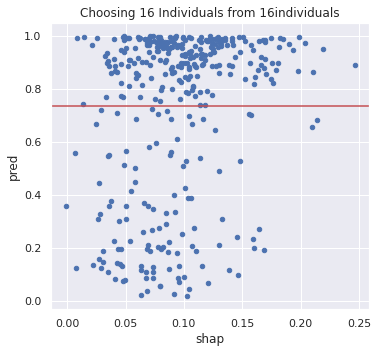

In SHAP Method Number of people changed 0 and total number 145 
Number of people in each quadrant  3 84 58 0
0
People taken from Quadrant 1 and 3  0
ID 's left to take  Adfter Quadrant 1 and 3  0
Number of ids changed in the end  0
Number of people with equal predictions in self  145

Original group 0 model:
Accuracy:	0.966
F.P. cost:	0.247
F.N. cost:	0.104
Base rate:	0.735
Avg. score:	0.724

Original group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633

SHAP Fairness Calibrated Equalized odds group 0 model:
Accuracy:	0.966
F.P. cost:	0.247
F.N. cost:	0.114
Base rate:	0.735
Avg. score:	0.717

SHAP Fairness Calibrated Equalized odds group 1 model:
Accuracy:	0.979
F.P. cost:	0.224
F.N. cost:	0.103
Base rate:	0.607
Avg. score:	0.633



In [ ]:

_, _, mix_rates = Model.calib_eq_odds(group_0_val_model, group_1_val_model, fp_rate, fn_rate, True)



print()
print("---------------Calculated Mix Rates and Applying to test models-----------")
print()
 
calib_eq_odds_group_0_test_model_shap, calib_eq_odds_group_1_test_model_shap = Model.calib_eq_odds(group_0_test_model,
                                                                                         group_1_test_model,
                                                                                         fp_rate, fn_rate,True,
                                                                                         mix_rates)




# Print results on test model
print()
print('Original group 0 model:\n%s\n' % repr(group_0_test_model))
print('Original group 1 model:\n%s\n' % repr(group_1_test_model))
print('SHAP Fairness Calibrated Equalized odds group 0 model:\n%s\n' % repr(calib_eq_odds_group_0_test_model_shap))
print('SHAP Fairness Calibrated Equalized odds group 1 model:\n%s\n' % repr(calib_eq_odds_group_1_test_model_shap))

In [ ]:
shap_df = pd.DataFrame(shap_values, columns = X.columns)
shap_changed_ids = calib_eq_odds_group_1_test_model_shap.get_changed_id()
print(shap_changed_ids)
shap_pred = data_final.loc[shap_changed_ids, 'pred']
shap_shap = shap_df.loc[shap_changed_ids, 'female']

randomized_changed_ids =  calib_eq_odds_group_1_test_model.get_changed_id()
random_pred = data_final.loc[randomized_changed_ids, 'pred']
random_shap = shap_df.loc[randomized_changed_ids, 'female']


base_rate =  calib_eq_odds_group_1_test_model_shap.base_rate()

common_ids = set(shap_changed_ids).intersection(set(randomized_changed_ids))
print(common_ids)
print("The lenght of the unique ids in shap is %d" % len(np.unique(shap_changed_ids)))
print("The lenght of the unique ids in randmoized is %d" % len(np.unique(randomized_changed_ids)))
print("The lenght of the unique ids in common to shap and random is %d" % len(np.unique(list(common_ids))))

shap_changed_data =  data_final.loc[shap_changed_ids, X.columns.values.tolist() + ['pred']]
randomized_changed_data =  data_final.loc[randomized_changed_ids, X.columns.values.tolist() + ['pred']]

print("The lenght of the shap_shap list is %d" % len(shap_shap))
print( len(shap_shap))


[]
set()
The lenght of the unique ids in shap is 0
The lenght of the unique ids in randmoized is 0
The lenght of the unique ids in common to shap and random is 0
The lenght of the shap_shap list is 0
0


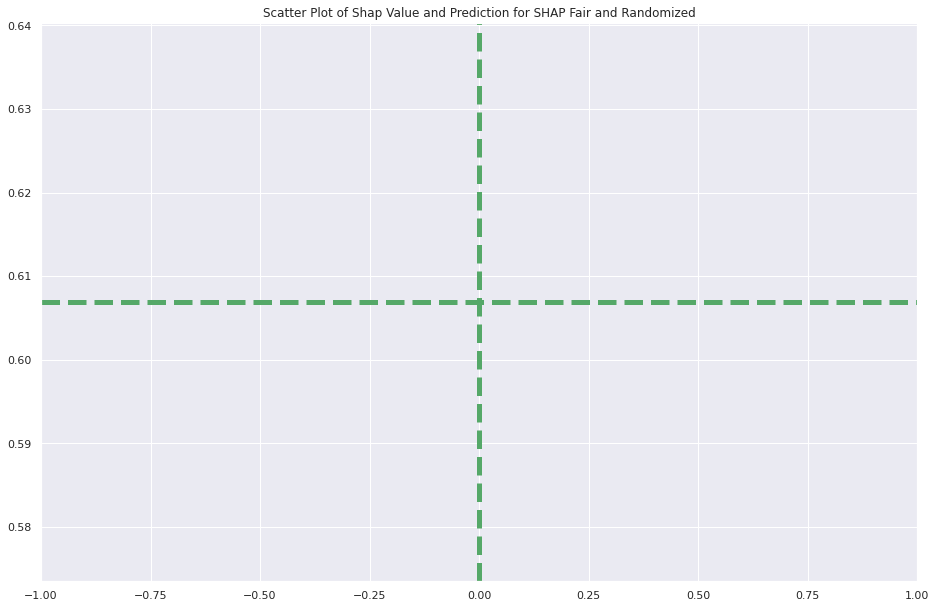

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(15.7,10.27)})
weights_shap = [200*i for i in Counter(shap_shap).values() for j in range(i)]
weights_random = [200*i for i in Counter(random_shap).values() for j in range(i)]

sns.scatterplot(shap_shap, shap_pred, weights_shap, color = 'b', alpha = 0.1)#, s = )
sns.scatterplot(random_shap, random_pred, weights_random, color = 'r', alpha = 0.1)#, s = weights_random)
plt.xlim([-1,1])
plt.title('Scatter Plot of Shap Value and Prediction for SHAP Fair and Randomized')
plt.axhline(y=base_rate, color='g', linestyle='--', linewidth = 5)
plt.axvline(x=0, color='g', linestyle='--', linewidth = 5)